### Initialise and read in datasets

In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "pandas<2.0.0"

  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.0.14 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import kDNA_annotation as ka
import re
import pathlib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from random import sample, randint, choice
from scipy.stats import hypergeom, norm, binom
from scipy.stats import chi2_contingency, ttest_ind, levene, f, kruskal, chi2
from collections import Counter, OrderedDict
from matplotlib.colors import colorConverter as cC
from matplotlib.patches import Rectangle
from statsmodels.formula.api import ols

def set_prefix(prefix):
    fig_dir = f'{prefix}_Figures'
    tab_dir = f'{prefix}_Tables'
    config_file = f'config_{prefix}.yaml'
    return(fig_dir,tab_dir,config_file)
    
#fig_dir,tab_dir,config_file=set_prefix('Antat_corrected')
#fig_dir,tab_dir,config_file=set_prefix('L427_corrected')
#fig_dir,tab_dir,config_file=set_prefix('IL3000')
#fig_dir,tab_dir,config_file=set_prefix('UPKZN')
#fig_dir,tab_dir,config_file=set_prefix('Kapeya')
#fig_dir,tab_dir,config_file=set_prefix('Antat')
#fig_dir,tab_dir,config_file=set_prefix('Te-Ap-ND1')
#fig_dir,tab_dir,config_file=set_prefix('OVI_strains')
#fig_dir,tab_dir,config_file=set_prefix('Tbg1_uncorrected_mRNA')
#fig_dir,tab_dir,config_file=set_prefix('Tbg1_corrected_mRNA')
#fig_dir,tab_dir,config_file=set_prefix('Tbg1_104AT')
fig_dir,tab_dir,config_file=set_prefix('Tbg1_LiTat-1-3')
#fig_dir,tab_dir,config_file=set_prefix('Tbg1_KIN-1')
#fig_dir,tab_dir,config_file=set_prefix('Tbg1_340AT')
#fig_dir,tab_dir,config_file=set_prefix('Tbg1_Mongo')

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.format'] = 'png'

date = datetime.datetime.now().strftime(r"%Y-%m-%d")

#fig_dir = 'Figures'
#tab_dir = 'Tables'
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True) 
pathlib.Path(tab_dir).mkdir(parents=True, exist_ok=True) 

#config_file = 'config_L427.yaml'
config = ka.load_config(config_file)
work_dir, annotation_dir = ka.get_directories(config)[1:3]

features_file = f"{work_dir}/{config['features pickle file']}"

minicircles, mRNAs, CSB1, CSB2, CSB3, cassettes, gRNAs_all = ka.gzip_pickle_load(features_file)

# drop gRNAs that edit version 2 of A6 and ND8
gRNAs = gRNAs_all[~gRNAs_all['mRNA_name'].str.contains('v2')]

def get_cas_seq(cassette, minicircles):
    # get full sequence of cassette
    s = cassette['forward_start']
    e = cassette['reverse_end']
    return str(minicircles[cassette['mO_name']].seq)[s:e]

cassettes['sequence'] = cassettes.apply(get_cas_seq, args=(minicircles,), axis=1)

file config_Tbg1_LiTat-1-3.yaml loaded
file /home/jovyan/gRNA_analysis/Work_files_Tbg1_LiTat-1-3/features.pickle.gz loaded


### Process gRNA gene families

In [4]:
def get_mO_structures(group_gRNAs, mO_cassettes):
    # return each minicircle and its gRNA families for each gRNA family
    mOs = pd.DataFrame(group_gRNAs['mO_name'])
    return mOs.merge(mO_cassettes)

gRNAs_tmp = gRNAs[['mO_name', 'cassette_label', 'family_id']].query('cassette_label != "Maxi"')
cas_tmp = cassettes[['mO_name', 'cassette_label']]
cas_tmp = cas_tmp.merge(gRNAs_tmp, how='left')
# set non-canonicals as nc
cas_tmp['family_id'].replace({np.nan:'nc'}, inplace=True)
# append the orphans 
cas_tmp = cas_tmp.append(gRNAs_tmp.query('cassette_label == "Orphan"')).reset_index(drop=True)
cas_tmp = cas_tmp.set_index(['mO_name', 'cassette_label'])

######### MINICIRCLES IN EACH gRNA family #####################
mO_cassettes = cas_tmp.reset_index()
# for each gRNA family create a list of all minicircles and their cassette family_ids
# this does not contain cas_tmp with noncanonical gRNAs_tmp yet
gRNA_family_mOs = gRNAs_tmp.groupby('family_id').apply(get_mO_structures, *(mO_cassettes,)).droplevel(1)
# rename gRNA family so we can merge with mO_cassettes
gRNA_family_mOs = gRNA_family_mOs.rename_axis('gRNA_family_id').reset_index()
# merge with mO_cassettes to populate with cas_tmp without gRNAs_tmp, these will be noncanonicals (nc)
gRNA_family_mOs = gRNA_family_mOs.merge(mO_cassettes, how='right')
# remove V1 from A6 and ND8
gRNA_family_mOs['gRNA_family_id'] = gRNA_family_mOs['gRNA_family_id'].str.replace('_v1', '')
gRNA_family_mOs['family_id'] = gRNA_family_mOs['family_id'].str.replace('_v1', '')
# to get cassette_label as columns containing family_ids:
# create multiindex
gRNA_family_mOs = gRNA_family_mOs.set_index(['gRNA_family_id', 'mO_name', 'cassette_label'])
# remove duplicate indicies
gRNA_family_mOs = gRNA_family_mOs.loc[~gRNA_family_mOs.index.duplicated(keep='first')]
# then unstack cassette_label
gRNA_family_mOs = gRNA_family_mOs.unstack(level='cassette_label')

########## gRNA families IN EACH MINICIRCLE ####################
# remove duplicates
mO_gRNA_families = cas_tmp.loc[~cas_tmp.index.duplicated(keep='first')]
# unstack to get cassette_label as columns
mO_gRNA_families = mO_gRNA_families.unstack(level='cassette_label')
# reindex to move orphans to end
mO_gRNA_families = mO_gRNA_families.reindex(['I', 'II', 'III', 'IV', 'V', 'Orphan'], axis=1, level=1)


# output to excel
mO_gRNA_families.to_excel(f'{tab_dir}/mO_gRNA_families_{date}.xlsx')
gRNA_family_mOs.to_excel(f'{tab_dir}/gRNA_family_mOs_{date}.xlsx')

print('Done')


/tmp/ipykernel_1340/1743041663.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cas_tmp = cas_tmp.append(gRNAs_tmp.query('cassette_label == "Orphan"')).reset_index(drop=True)


Done


### Coverage statistics

Report coverage statistics of gRNAs for each mRNA. Report predicted number of missing gRNAs for each mRNA.

In [5]:
min_anchor_length = 6

columns = [
    'product',
    'total gRNAs',
    'missing gRNAs',
    'insertions',
    'insertions covered',
    'insertions not covered',
    'deletions',
    'deletions covered',
    'deletions not covered'
    ]
df_data = OrderedDict([(c, []) for c in columns])

for mRNA_name, mRNA_record in sorted(mRNAs.items()):
    if mRNA_name == 'COX2':
        continue
    gRNA_records = gRNAs_all.query('mRNA_name == @mRNA_name')
    mRNA_seq = mRNA_record['seq']
    gRNA_exists = np.zeros(len(mRNA_seq))
    no_gRNAs = 0

    for _, gRNA in gRNA_records.iterrows():
        no_gRNAs += 1

        start = gRNA['mRNA_start']
        end   = gRNA['mRNA_end']-min_anchor_length
        gRNA_exists[start:end] += 1

    insertions    = np.array(list(mRNA_seq)) == 'u'
    insert_exists = [i and (g>0) for i, g in zip(insertions, gRNA_exists) if i]
    deletions     = [0 if i == '-' else int(i) for i in mRNA_record['deletions']]

    x, no_missing = 0, 0
    while x < len(mRNA_seq):
        if (insertions[::-1][x] or deletions[::-1][x]) and not gRNA_exists[::-1][x]:
            x += 40-min_anchor_length
            no_missing += 1
        else:
            x += 1

    df_data['product'].append(mRNA_name)
    df_data['total gRNAs'].append(no_gRNAs)
    df_data['missing gRNAs'].append(no_missing)
    df_data['insertions'].append(len(insert_exists))
    df_data['insertions covered'].append(insert_exists.count(True))
    df_data['insertions not covered'].append(insert_exists.count(False))
    df_data['deletions'].append(sum(deletions))
    df_data['deletions covered'].append(sum([i for i, g in zip(deletions, gRNA_exists) if i and (g>0) ]))
    df_data['deletions not covered'].append(sum([i for i, g in zip(deletions, gRNA_exists) if i and (g==0) ]))
df = pd.DataFrame(df_data)

total = df.apply(np.sum)
total['product'] = 'total'
df = df.append(pd.DataFrame(total.values, index=total.keys()).T, ignore_index=True)

df.to_excel(f'{tab_dir}/coverage_{date}.xlsx')

print(df.to_string(index=False))

product total gRNAs missing gRNAs insertions insertions covered insertions not covered deletions deletions covered deletions not covered
  A6_v1          37             2        443                433                     10        28                24                     4
  A6_v2          35             2        444                440                      4        28                28                     0
COX3_v1          43            10        544                447                     97        42                37                     5
COX3_v2          38            12        544                431                    113        42                36                     6
    CR3           4             5        142                 66                     76        10                 4                     6
    CR4          14             7        328                217                    111        44                24                    20
    CYB           1             1        

/tmp/ipykernel_1340/2006393733.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(total.values, index=total.keys()).T, ignore_index=True)


### Minicircle structures

##################################################
median positions of middles of each cassette label
##################################################
cassette_label
I      250.75
II     431.50
III    515.50
IV     661.25
V      800.50
Name: mid, dtype: float64


/tmp/ipykernel_1340/1108743143.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for label, pos in groups.iteritems():


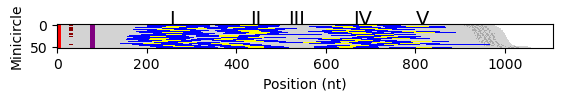

In [6]:
mOs = {'mO_name':[], 'length':[], 'seq':[]}
for mO_name, record in minicircles.items():
    mOs['mO_name'].append(mO_name)
    mOs['length'].append(len(record.seq))
    mOs['seq'].append(str(record.seq))
mOs = pd.DataFrame(mOs).sort_values('length', ascending=True).reset_index()

CSB1_tmp = pd.DataFrame(CSB1).T
CSB2_tmp = pd.DataFrame(CSB2).T
CSB3_tmp = pd.DataFrame(CSB3).T
CSB1_tmp.index.name = 'mO_name'
CSB2_tmp.index.name = 'mO_name'
CSB3_tmp.index.name = 'mO_name'
CSB1_tmp = CSB1_tmp.merge(mOs, on='mO_name')
CSB2_tmp = CSB2_tmp.merge(mOs, on='mO_name')
CSB3_tmp = CSB3_tmp.merge(mOs, on='mO_name')
cas_tmp = cassettes.merge(mOs, on='mO_name')
gRNAs_tmp = gRNAs_all.dropna(subset=['circle_start', 'circle_end']).merge(mOs, on='mO_name')

img = np.ones((len(mOs), mOs['length'].max(), 3))*cC.to_rgb('White')
for i, c in mOs.iterrows():
    l = c['length']
    y = np.where(np.array(list(c['seq'])) == 'A')[0]
    y = y[(y > l-70) & (y < l-20)]
    img[i, :l] = cC.to_rgb('LightGray')
    img[i, y] = cC.to_rgb('DarkGrey')

for _, c in CSB1_tmp.iterrows():
    img[c['index'], c['start']:c['end']] = cC.to_rgb('Red')

for _, c in CSB2_tmp.iterrows():
    img[c['index'], c['start']:c['end']] = cC.to_rgb('DarkRed')

for _, c in CSB3_tmp.iterrows():
    img[c['index'], c['start']:c['end']] = cC.to_rgb('Purple')

for _, c in cas_tmp.iterrows():
    img[c['index'], c['forward_start']:c['reverse_end']] = cC.to_rgb('Blue')
    
for _, c in gRNAs_tmp.iterrows():
    img[c['index'], c['circle_start']:c['circle_end']] = cC.to_rgb('Yellow')
    
    
fig = plt.imshow(img, interpolation='none')
plt.xlabel('Position (nt)')
plt.ylabel('Minicircle')
cas_tmp['mid'] = (cas_tmp['forward_start']+cas_tmp['reverse_end'])/2
groups = cas_tmp.groupby('cassette_label')['mid'].median()

print('##################################################')
print("median positions of middles of each cassette label")
print('##################################################')
print(groups)

for label, pos in groups.iteritems():
    plt.annotate(label, (pos, 0), size=14)

plt.savefig(f'{fig_dir}/structure_{date}')

### Distribution of number of cassettes per minicircle

In [7]:
g = cassettes.groupby(['mO_name'])['type'].count()
print(f'cassettes frequency\n{g.value_counts()}')


cassettes frequency
3    29
4    15
2     1
Name: type, dtype: int64


### Numbers of different types of gRNAs and gRNAs per cassette

In [8]:
def ngRNAs(gRNAs):
    if len(gRNAs) == 2:
        if ('_v' in gRNAs.iloc[0]['mRNA_name'] and '_v' in gRNAs.iloc[1]['mRNA_name']
         and gRNAs.iloc[0]['product'] == gRNAs.iloc[0]['product']):
            return 1
    return len(gRNAs)

maxi = gRNAs_all['mO_name'].str.startswith('Maxi')
nmaxi = len(gRNAs_all[maxi])
orphan = gRNAs_all['cassette_label'] == 'Orphan'
norphan = len(gRNAs_all[orphan])

cas_gRNAs = gRNAs_all[~(maxi | orphan)]

canon = cassettes.query('type == "canonical"')

gpc = cas_gRNAs.groupby(['mO_name', 'cassette_label']).apply(ngRNAs)
print(f'number of cassettes = {len(cassettes)}')
print(f'number of maxicircle gRNAs = {nmaxi}')
print(f'number of orphans gRNAs = {norphan}')
print(f'cassettes with canonical gRNAs = {len(canon)}')
print(f'cassettes with non-canonical gRNAs = {len(cassettes)-len(canon)}')
print('###################################')
print('distribution of gRNAs per cassette:')
print('###################################')
print(gpc.value_counts())
print('###################################')
print('cassettes with multiple gRNAs')
print('###################################')
print(gpc[gpc == 2])
antisense = gRNAs.query('strand == "template"')
print(f'number of gRNAs on anti-sense strand = {len(antisense)}')


number of cassettes = 149
number of maxicircle gRNAs = 1
number of orphans gRNAs = 3
cassettes with canonical gRNAs = 108
cassettes with non-canonical gRNAs = 41
###################################
distribution of gRNAs per cassette:
###################################
1    104
3      3
2      1
dtype: int64
###################################
cassettes with multiple gRNAs
###################################
mO_name  cassette_label
mO_026   IV                2
dtype: int64
number of gRNAs on anti-sense strand = 1


### Cassette position by gRNA type

Also test if cassette I has more non-canonical gRNAs than the other cassettes positions

In [9]:
x = cassettes
t = pd.crosstab(x['cassette_label'], x['type'], margins=True)
print(t)
t = pd.crosstab(x['cassette_label'], x['type'], normalize='index', margins=True)
print(round(t, 2))

print('##############################################################################')
print('Test if cassette position I has fewer canonical gRNAs than the other cassettes')
print('##############################################################################')
x['cc'] = x['cassette_label'].apply(lambda z: 'I' if z == 'I' else 'all others')
t = pd.crosstab(x['cc'], x['type'])
print(t)
r = chi2_contingency(t)
print(f'chi-sq = {r[0]}')
print(f'p = {r[1]}')
print(f'dof = {r[2]}')

type            canonical  non-canonical  All
cassette_label                               
I                      28             15   43
II                     34             10   44
III                     2              0    2
IV                     34             10   44
V                      10              6   16
All                   108             41  149
type            canonical  non-canonical
cassette_label                          
I                    0.65           0.35
II                   0.77           0.23
III                  1.00           0.00
IV                   0.77           0.23
V                    0.62           0.38
All                  0.72           0.28
##############################################################################
Test if cassette position I has fewer canonical gRNAs than the other cassettes
##############################################################################
type        canonical  non-canonical
cc                            

### Cassette size

#######################
Stats on cassette size
#######################
count    149.000000
mean     142.067114
std        4.711493
min      123.000000
25%      139.000000
50%      142.000000
75%      145.000000
max      156.000000
Name: size, dtype: float64
###############################
Stats on cassette size by type
###############################
               count   mean  std    min    25%    50%    75%    max
type                                                               
canonical      108.0  142.9  3.9  135.0  140.0  143.0  145.0  156.0
non-canonical   41.0  139.9  5.9  123.0  136.0  139.0  142.0  156.0
###############################
levene test for equal variances
###############################
type
canonical        3.9
non-canonical    5.9
Name: size, dtype: float64
upper critical value of F_c=F_(0.05, 1, 147) = 3.91
W = 6.18, p = 0.014

########################################
Kruskal-Wallace test for equal variances
########################################
type
cano

/tmp/ipykernel_1571/1922371645.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  size_by_group = [g['size'].values for _, g in grouped]
/tmp/ipykernel_1571/1922371645.py:39: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(x='type', y='size', inner='quartile',


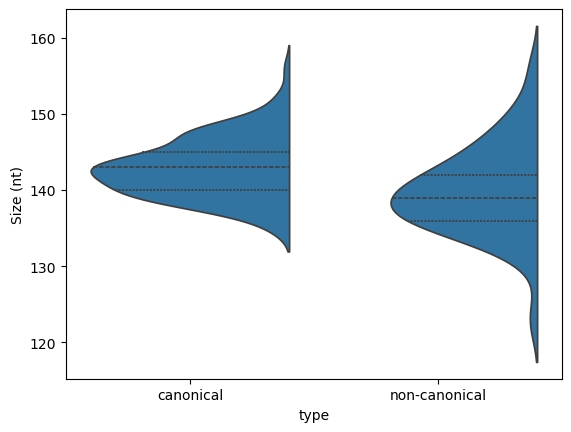

In [10]:
cas_copy = copy(cassettes)
cas_copy['size'] = cas_copy['reverse_end']-cas_copy['forward_start']
grouped = cas_copy.groupby(['type'])
size_by_group = [g['size'].values for _, g in grouped]
k = len(grouped)
N = len(cas_copy)

print('#######################')
print('Stats on cassette size')
print('#######################')
print(cas_copy['size'].describe())
print('###############################')
print('Stats on cassette size by type')
print('###############################')
print(grouped['size'].describe().round(1).to_string())
# print(cas_copy.groupby('type')['size'].describe())

print('###############################')
# test for equal variance of cassette size between type
print('levene test for equal variances')
print('###############################')
print(grouped['size'].std().round(1))
statistic, pvalue = levene(*size_by_group, center='mean')
print(f'upper critical value of F_c=F_(0.05, {k-1}, {N-k}) = {f.ppf(1-0.05, k-1, N-k):.2f}')
print(f'W = {statistic:.2f}, p = {pvalue:.2g}\n')

# test for equal means by type
print('########################################')
print('Kruskal-Wallace test for equal variances')
print('########################################')
print(grouped['size'].mean().round(1))
#statistic, pvalue = kruskal(*size_by_group, center='mean')
statistic, pvalue = kruskal(*size_by_group)
print(f'upper critical value of H_c=chisq_(0.05, {k-1}) = {chi2.ppf(1-0.025, k-1):.2f}')
print(f'H = {statistic:.2f}, p = {pvalue:.2g}\n')
r = ols('size ~ type', data=cas_copy).fit()
print(r.summary())

ax = sns.violinplot(x='type', y='size', inner='quartile', 
    split=True, order=('canonical', 'non-canonical'), 
    data=cas_copy, scale='area')
ax.set_ylabel('Size (nt)')
plt.savefig(f'{fig_dir}/cassette_size_by_type_{date}')


### Watson-Crick and GU matches between inverted repeats

In [11]:
def matches(cassette):
    match = {'AT':1, 'TA':1, 'GC':1, 'CG':1, 'GT':1, 'TG':1}
    return sum([1 if f+r in match else 0 for f, r in zip(cassette['forward_seq'], cassette['reverse_seq'][::-1])])

cassettes['matches'] = cassettes.apply(matches, axis=1)
print(cassettes['matches'].describe())


count    149.000000
mean      16.060403
std        1.146252
min       12.000000
25%       15.000000
50%       16.000000
75%       17.000000
max       18.000000
Name: matches, dtype: float64


### Cassette structure

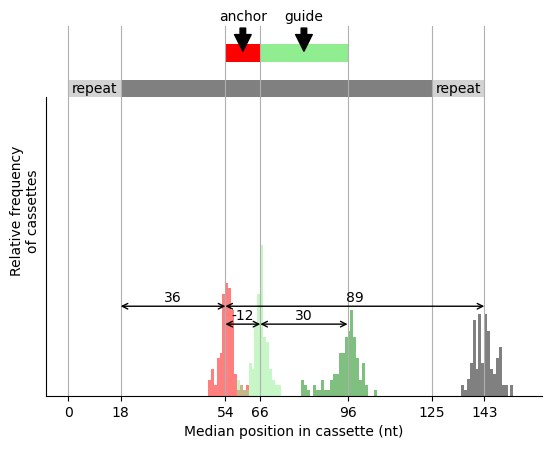

In [12]:
# drop genes without sequence
gRNAs_tmp = gRNAs.query('cassette_label != "Orphan"')
# merge with cassettes to get all canonical cassettes (ecc)
ecc = gRNAs_tmp.merge(cassettes[['mO_name', 'cassette_label', 'forward_start', 'reverse_end']])
ecc['cassette_centre'] = (ecc['reverse_end']-ecc['forward_start'])/2

ecc['cas_length'] = ecc['reverse_end'] - ecc['forward_start']
colour = {
    'repeat':'LightGrey',
    'cassette':'Grey',
    'anchor':'Red',
    'guide':'LightGreen',
    'gRNA':'Green',
    }

gRNA_start = ecc['rel_start']+18
guide_start = ecc['rel_start']+ecc['anchor_len']+18
gRNA_end = ecc['rel_start']+ecc['length']+18
cas_end = ecc['cas_length']

xc = (0, gRNA_start.median(), guide_start.median(), gRNA_end.median(), cas_end.median())
r = range(156)

fig, axes = plt.subplots(1, 1)
axes.hist(gRNA_start, density=True, bins=r, alpha=0.5, color=colour['anchor'])
axes.hist(guide_start, density=True, bins=r, alpha=0.5, color=colour['guide'])
axes.hist(gRNA_end, density=True, bins=r, alpha=0.5, color=colour['gRNA'])
axes.hist(cas_end, density=True, bins=r, color=colour['cassette'])
y = 0.5
dy = 0.03
axes.add_patch(Rectangle((0, y), 18, dy, color=colour['repeat'], linewidth=0, fill=True))
axes.add_patch(Rectangle((18, y), cas_end.median()-36, dy, color=colour['cassette'], linewidth=0, fill=True))
axes.add_patch(Rectangle((xc[1], y+2*dy), xc[2]-xc[1], dy, color=colour['anchor'], linewidth=0, fill=True))
axes.add_patch(Rectangle((xc[2], y+2*dy), xc[3]-xc[2], dy, color=colour['guide'], linewidth=0, fill=True))
axes.add_patch(Rectangle((xc[4]-18, y), 18, dy, color=colour['repeat'], linewidth=0, fill=True))

axes.annotate('repeat', (9, y+0.5*dy), ha='center', va='center')
xp, yp = ((xc[1]+xc[2])/2, y+2.5*dy)
axes.annotate('anchor', xy=(xp, yp), xytext=(xp, yp+2*dy), ha='center', va='center',
        arrowprops=dict(facecolor='black', shrink=0.05))
xp, yp = ((xc[2]+xc[3])/2, y+2.5*dy)
axes.annotate('guide', xy=(xp, yp), xytext=(xp, yp+2*dy), ha='center', va='center',
        arrowprops=dict(facecolor='black', shrink=0.05))
axes.annotate('repeat', (xc[4]-9, y+0.5*dy), ha='center', va='center')

y = 0.12
a1 = {'arrowstyle': '->', 'shrinkA':0, 'shrinkB':0}
a2 = {'arrowstyle': '<->', 'shrinkA':0, 'shrinkB':0}
axes.annotate('', xy=(18, y+dy), xytext=(xc[1], y+dy), arrowprops=a2)
axes.annotate('', xy=(xc[1], y+dy), xytext=(xc[4], y+dy), arrowprops=a2)
axes.annotate('', xy=(xc[1], y), xytext=(xc[2], y), arrowprops=a2)
axes.annotate('', xy=(xc[2], y), xytext=(xc[3], y), arrowprops=a2)

axes.annotate(int(xc[1]-18), xy=((18+xc[1])/2, y+dy), xytext=(0, 3), textcoords='offset points', ha='center')
axes.annotate(int(xc[4]-xc[1]), xy=((xc[1]+xc[4])/2, y+dy), xytext=(0, 3), textcoords='offset points', ha='center')
axes.annotate(int(xc[1]-xc[2]), xy=((xc[1]+xc[2])/2, y), xytext=(0, 3), textcoords='offset points', ha='center')
axes.annotate(int(xc[3]-xc[2]), xy=((xc[2]+xc[3])/2, y), xytext=(0, 3), textcoords='offset points', ha='center')

axes.set_xticks((0, 18, xc[1], xc[2], xc[3], xc[4]-18, xc[4]))
axes.set_yticks([])
axes.set_xlabel('Median position in cassette (nt)')
axes.set_ylabel('Relative frequency\nof cassettes')
axes.grid(which='both', axis='x')

# Move bottom spine
axes.spines['left'].set_bounds(0, 0.5)
# Hide spines
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
# Only show ticks on the bottom spines
axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')
fig.savefig(f'{fig_dir}/cassette_structure_{date}')



### gRNA complementarity

#####################
Stats on gRNA length
#####################
count    115.000000
mean      40.547826
std        5.593297
min       25.000000
25%       39.000000
50%       41.000000
75%       44.000000
max       52.000000
Name: length, dtype: float64
#####################
Stats on anchor length
#####################
count    115.000000
mean      11.565217
std        2.734222
min        6.000000
25%       10.000000
50%       11.000000
75%       13.000000
max       19.000000
Name: anchor_len, dtype: float64
#####################
Stats on guide length
#####################
count    115.000000
mean      28.982609
std        4.723927
min       14.000000
25%       27.000000
50%       30.000000
75%       32.000000
max       40.000000
dtype: float64


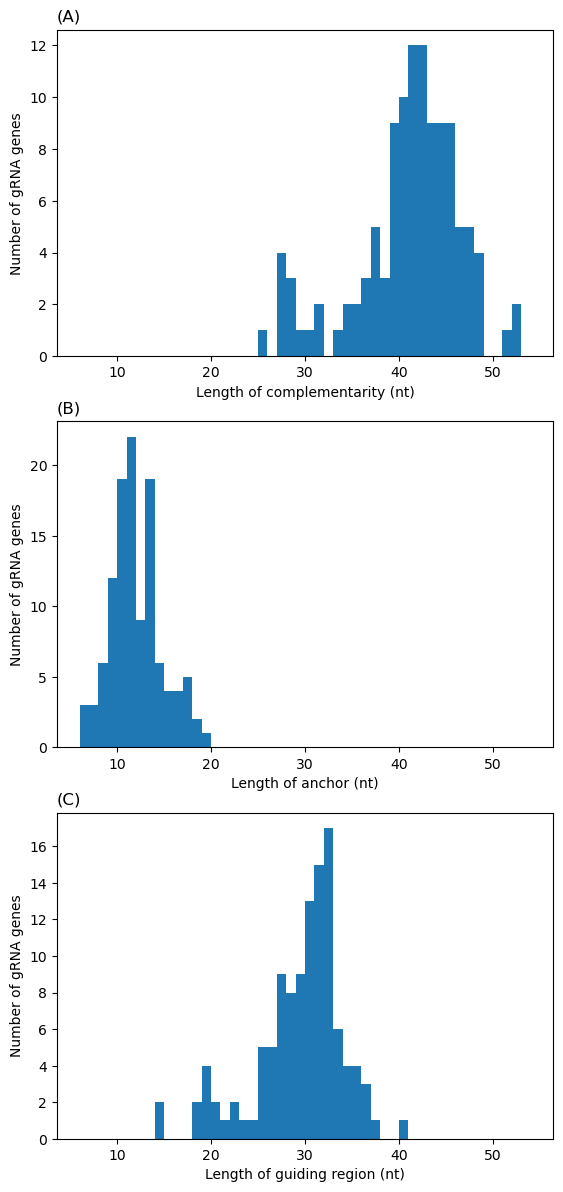

In [13]:
gRNAs_tmp = gRNAs

print('#####################')
print('Stats on gRNA length')
print('#####################')
print(gRNAs_tmp['length'].describe())
print('#####################')
print('Stats on anchor length')
print('#####################')
print(gRNAs_tmp['anchor_len'].describe())
print('#####################')
print('Stats on guide length')
print('#####################')
print((gRNAs_tmp['length']-gRNAs_tmp['anchor_len']).describe())

fig, axes = plt.subplots(3, 1, figsize=(6.4, 3*4.8))
x = range(6, 55)
axes[0].hist(gRNAs_tmp['length'], bins=x)
axes[1].hist(gRNAs_tmp['anchor_len'], bins=x)
axes[2].hist(gRNAs_tmp['length']-gRNAs['anchor_len'], bins=x)

axes[0].set_ylabel('Number of gRNA genes')
axes[1].set_ylabel('Number of gRNA genes')
axes[2].set_ylabel('Number of gRNA genes')
axes[0].set_xlabel('Length of complementarity (nt)')
axes[1].set_xlabel('Length of anchor (nt)')
axes[2].set_xlabel('Length of guiding region (nt)')
for t, axes in zip('ABC', axes):
    axes.set_title(f'({t})', loc='left')
    
fig.savefig(f'{fig_dir}/gRNA_complementarity_{date}')


### gRNA nucleotide biases

Nucleotide frequencies along gRNAs starting from 30nt downstream from the 3' end of the forward 18bp inverted repeat.

Red rectangle shows the anchor region, green rectangle shows the guiding region.

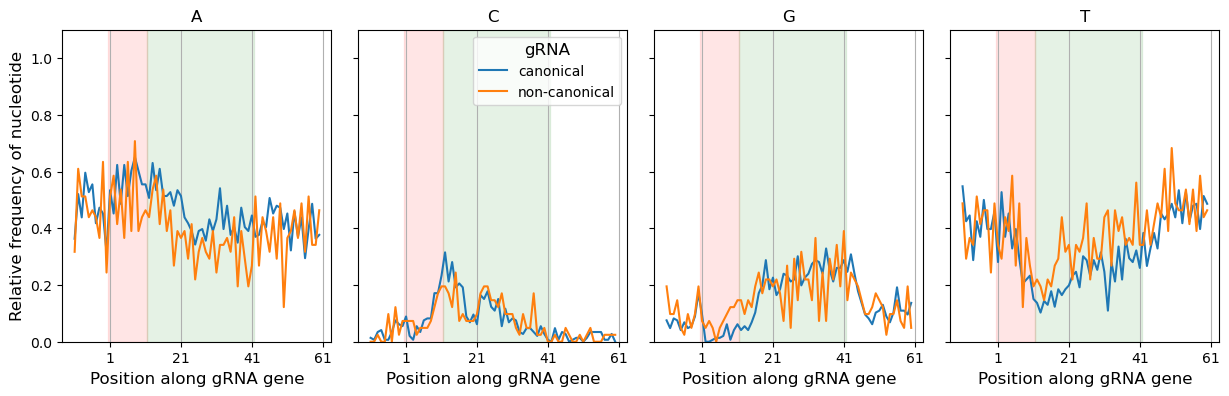

In [14]:
def calculate_biases(group, length):
    # set up matrices of nucleotide frequencies along sequences
    count = {i: Counter() for i in range(length)}
    for seq in group.values:
        for i, b in enumerate(seq):
            count[i][b] += 1

    for i in range(len(count)):
        total = sum(count[i].values())
        for b in 'ACGT':
            count[i][b] /= total
    return pd.DataFrame.from_dict(count, orient='index')

def get_ne_seq(c, start, length):
    s = 30+18+start
    return c['sequence'][s:s+length]

start = -10
length = 70

gRNAs_tmp = gRNAs_all[['mO_name', 'cassette_label', 'strand', 'rel_start']]
ne_cassettes = cassettes.merge(gRNAs_tmp, how='left')

ne_cassettes['gRNA_seq'] = ne_cassettes.apply(get_ne_seq, axis=1, args=(start, length))
# calculate nt biases
ne_biases = ne_cassettes.groupby('type')['gRNA_seq'].apply(calculate_biases, length).reset_index().drop('level_1', axis=1).set_index('type')

color = it.cycle(('C0', 'C1'))
fig, axes = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(13, 4), squeeze=False)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, wspace=0.1, hspace=0.4)
for col, base in enumerate(sorted(ne_biases.columns)):
    for gRNA_type in ['canonical', 'non-canonical']:
        axes[0, col].plot(np.arange(length)+start, ne_biases.loc[gRNA_type, base], color=next(color), label=f'{gRNA_type}')
        axes[0, col].set_xticks(range(-20, 61, 20))
        axes[0, col].set_xticklabels(range(-19, 62, 20))

for col, base in enumerate(sorted(ne_biases.columns)):
    axes[0, col].set_title(base)
    axes[0, col].set_xlabel('Position along gRNA gene', fontsize=12)
    axes[0, col].tick_params('x', labelbottom=True)
axes[0, 0].set_ylabel('Relative frequency of nucleotide', fontsize=12)
axes[0, 1].legend(title='gRNA').get_title().set_fontsize(12)


for axis in axes.flatten():
    axis.grid(True, axis='x')
    axis.set_ylim(0, 1.1)
    axis.axvspan(-0.5, -0.5+11, color='r', alpha=0.1)
    axis.axvspan(-0.5+11, -0.5+41, color='g', alpha=0.1)

fig.savefig(f'{fig_dir}/gRNA_biases_{date}')

### Stats on gRNA gene families and unique minicircle classes

In [15]:
def format_gRNA_families(gRNAs, cassettes):
    def get_mO_structures(group_gRNAs, mO_cassettes):
        # return each minicircle and its gRNA families for each gRNA family
        mOs = pd.DataFrame(group_gRNAs['mO_name'])
        return mOs.merge(mO_cassettes)

    gRNAs = gRNAs[['mO_name', 'cassette_label', 'family_id']].query('cassette_label != "Maxi"')
    # gRNAs['expression'] = gRNAs['expression'].replace({'expressed':'+', 'non-expressed':'-'})
    cassettes = cassettes[['mO_name', 'cassette_label']]
    cassettes = cassettes.merge(gRNAs, how='left')
    # set non-canonicals as nc
    cassettes['family_id'].replace({np.nan:'nc'}, inplace=True)
    # append the orphans 
    cassettes = cassettes.append(gRNAs.query('cassette_label == "Orphan"')).reset_index(drop=True)
    cassettes = cassettes.set_index(['mO_name', 'cassette_label'])

   ######### MINICIRCLES IN EACH gRNA family #####################
    mO_cassettes = cassettes.reset_index()
    # for each gRNA family create a list of all minicircles and their cassette family_ids
    # this does not contain cassettes with noncanonical gRNAs yet
    gRNA_family_mOs = gRNAs.groupby('family_id').apply(get_mO_structures, *(mO_cassettes,)).droplevel(1)
    # rename gRNA family so we can merge with mO_cassettes
    gRNA_family_mOs = gRNA_family_mOs.rename_axis('gRNA_family_id').reset_index()
    # merge with mO_cassettes to populate with cassettes without gRNAs, these will be noncanonicals (nc)
    gRNA_family_mOs = gRNA_family_mOs.merge(mO_cassettes, how='right')
    # remove V1 from A6 and ND8
    gRNA_family_mOs['gRNA_family_id'] = gRNA_family_mOs['gRNA_family_id'].str.replace('_v1', '')
    gRNA_family_mOs['family_id'] = gRNA_family_mOs['family_id'].str.replace('_v1', '')
    # to get cassette_label as columns containing family_ids:
    # create multiindex
    gRNA_family_mOs = gRNA_family_mOs.set_index(['gRNA_family_id', 'mO_name', 'cassette_label'])
    # remove duplicate indicies
    gRNA_family_mOs = gRNA_family_mOs.loc[~gRNA_family_mOs.index.duplicated(keep='first')]
    # then unstack cassette_label
    gRNA_family_mOs = gRNA_family_mOs.unstack(level='cassette_label')

    ########## gRNA families IN EACH MINICIRCLE ####################
    # remove duplicates
    mO_gRNA_families = cassettes.loc[~cassettes.index.duplicated(keep='first')]
    # unstack to get cassette_label as columns
    mO_gRNA_families = mO_gRNA_families.unstack(level='cassette_label')
    # reindex to move orphans to end
    mO_gRNA_families = mO_gRNA_families.reindex(['I', 'II', 'III', 'IV', 'V', 'Orphan'], axis=1, level=1)

    return gRNA_family_mOs, mO_gRNA_families

def gRNA_family_stats(gRNAs, cassettes):
    gRNA_family_mOs, mO_gRNA_families = format_gRNA_families(gRNAs, cassettes)

    unique_mOs = mO_gRNA_families.drop_duplicates()

    print('##################################')
    print(f'num mOs = {len(mO_gRNA_families)}')
    print(f'num unique mOs based on gRNA families on each minicircle = {len(unique_mOs)}')
    print('##################################')

    print('Number of unique gRNAs per family')
    print(gRNAs.groupby('family_id')['mO_name'].count().describe())

gRNA_family_stats(gRNAs, cassettes)

/tmp/ipykernel_1571/1166896859.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cassettes = cassettes.append(gRNAs.query('cassette_label == "Orphan"')).reset_index(drop=True)


##################################
num mOs = 45
num unique mOs based on gRNA families on each minicircle = 45
##################################
Number of unique gRNAs per family
count    106.000000
mean       1.084906
std        0.280065
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: mO_name, dtype: float64


### Create network of gene families

In [16]:
gRNAs_tmp = gRNAs.query('cassette_label != "Maxi"')

G = nx.Graph()      # minicircles with edges to their gRNA families

# each gRNA family is a square node
for family_id in gRNAs_tmp['family_id'].unique():
    mRNA_name, pos, end = family_id.split('-')
    # remove 'v1' from mRNA_name
    mRNA_name = mRNA_name.replace('_v1', '')
    G.add_node(family_id, shape='square', width=.1, color='red', height=.1, label=f'{mRNA_name}-\n{pos}-{end}')

# Each minicircle is a circular node
for mO_name in gRNAs_tmp['mO_name'].unique():
    G.add_node(mO_name, shape='circle', width=.1, color='black', height=.1, label=mO_name[3:], fontsize=12, margin=0.01)
# link mOs to the gRNA families they contain
for _, gRNA in gRNAs_tmp.iterrows():
    G.add_edge(gRNA['mO_name'], gRNA['family_id'], style='dashed')
    
print('Done')

Done


### Adjacency mOs of a given gRNA family and its adjacent gRNA families in the network


In [17]:
family_ids = ['CR3-IV-281']

gRNAs = gRNAs.query('cassette_label != "Maxi"')

for l1_family_id in family_ids:
    # minicircles that encode this gRNA family
    l1_mOs = set(G[l1_family_id].keys())
    # get all gRNA families from these minicircles
    l2_family_ids = set()
    for mO in l1_mOs:
        l2_family_ids.update(set(G[mO].keys()))
        
    # get all other minicircles that link to these gRNA families
    l2_mOs = set()
    for family in l2_family_ids:
        l2_mOs.update(set(G[family].keys()))
        
    l2_mOs.difference_update(l1_mOs)

    print(f'------------------------ {l1_family_id} ----------------------------')
    print('###################################################')
    print(f'output all minicircles that encode {l1_family_id}')
    print(mO_gRNA_families.loc[l1_mOs].dropna(axis=1, how='all').to_string(na_rep=''))
    print('\n')
    print('###################################################')
    print(f'output all minicircles that encode families that are encoded on minicircles that encode {l1_family_id} ')
    print(mO_gRNA_families.loc[l2_mOs].dropna(axis=1, how='all').to_string(na_rep=''))
    

KeyError: 'CR3-IV-281'

### Plot gene family network

In [ ]:
aG = nx.nx_agraph.to_agraph(G)
aG.graph_attr.update(dpi='300')
aG.layout(prog='twopi')
# aG.draw(f'{fig_dir}/family_network_twopi_{date}.png')
aG.draw(f'{fig_dir}/family_network_twopi_{date}.pdf')